<a href="https://colab.research.google.com/github/shreyas-desai/Petals-to-the-Metal/blob/main/Petals_to_the_Metal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

In [ ]:
cp drive/MyDrive/kaggle.json ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c tpu-getting-started

100% 4.78G/4.79G [00:54<00:00, 186MB/s]
100% 4.79G/4.79G [00:54<00:00, 94.2MB/s]


In [ ]:
from zipfile import ZipFile

file = 'tpu-getting-started.zip'
with ZipFile(file,'r') as zip_file:
  zip_file.extractall()

In [ ]:
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import math, re,os
import pandas as pd
import numpy as np
import random
import plotly.express as px
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.13.210.138:8470
REPLICAS:  8


In [ ]:
TRAINING_FILENAMES = glob('/content/tfrecords-jpeg-192x192' + '/train/*.tfrec')
VALIDATION_FILENAMES = glob('/content/tfrecords-jpeg-192x192' + '/val/*.tfrec')
TEST_FILENAMES = glob('/content/tfrecords-jpeg-192x192'+'/test/*.tfrec')

In [ ]:
import os
IMAGE_SIZE = [192,192] #See Note 2.1 above 😀

AUTO = tf.data.AUTOTUNE #See Note 2.2 above 😀

TRAINING_FILENAMES = tf.io.gfile.glob(os.path.join('/content/tfrecords-jpeg-192x192'+'/train/*.tfrec'))
VALIDATION_FILENAMES = tf.io.gfile.glob(os.path.join('/content/tfrecords-jpeg-192x192'+'/val/*.tfrec'))
TEST_FILENAMES = tf.io.gfile.glob(os.path.join('/content/tfrecords-jpeg-192x192'+'/test/*.tfrec'))

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 103


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.deterministic = False # disable order, increase speed. #See Note 2.3 above 😀

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files. #See Note 2.2 above 😀
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [ ]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the next function (below), this happens essentially for free on TPU.
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO) #tuning4
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [ ]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync #See Note 3.1 above 😀

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [ ]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape) #See Note 3.1 above 😀
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
Training data label examples: [88 40 73 ... 92 73 28]


In [ ]:
print("Test data Shapes: ")
for image, ids in ds_test.take(3):
  print(image.numpy().shape, ids.numpy().shape)
print("ids",ids.numpy())

Test data Shapes: 
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
ids [b'386e40044' b'a8331323f' b'754cd2605' ... b'17ec6d74f' b'4fd5cd91f'
 b'08a1c14db']


In [ ]:
from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
        # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label],
                                'OK' if correct else 'NO',
                                u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None, display_mismatches_only=False):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        if display_mismatches_only:
            if predictions[i] != label:
                subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
        else:
            subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def display_training_curves_v2(training, validation, learning_rate_list, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title, color='b')
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.', 'learning rate'])

    ax2 = ax.twinx()
    ax2.plot(learning_rate_list, 'g-')
    ax2.set_ylabel('learning rate', color='g')

In [ ]:
ds_iter = iter(ds_train.unbatch().batch(20))

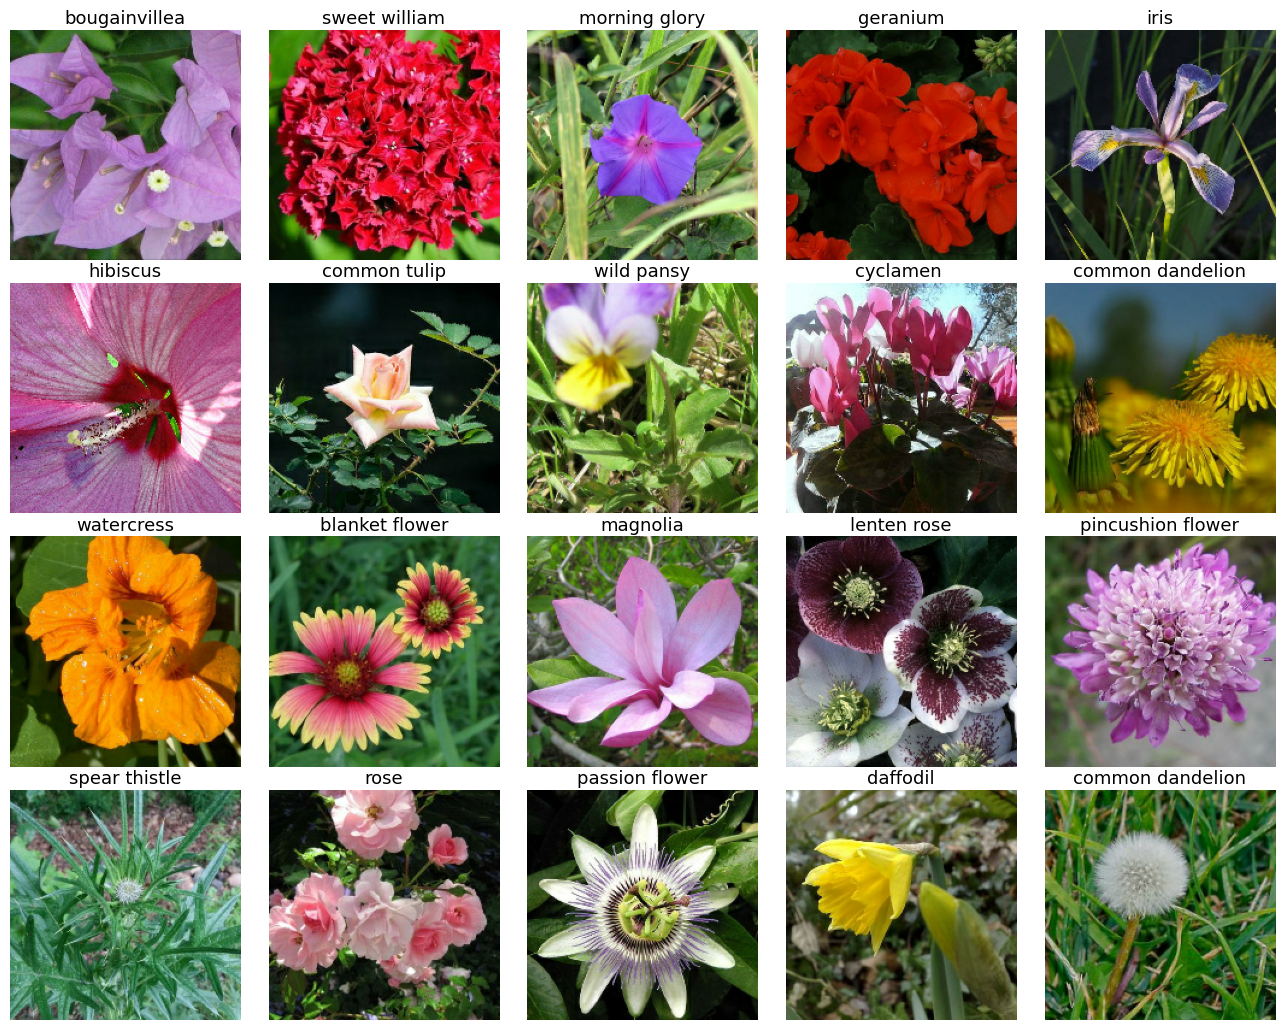

In [ ]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

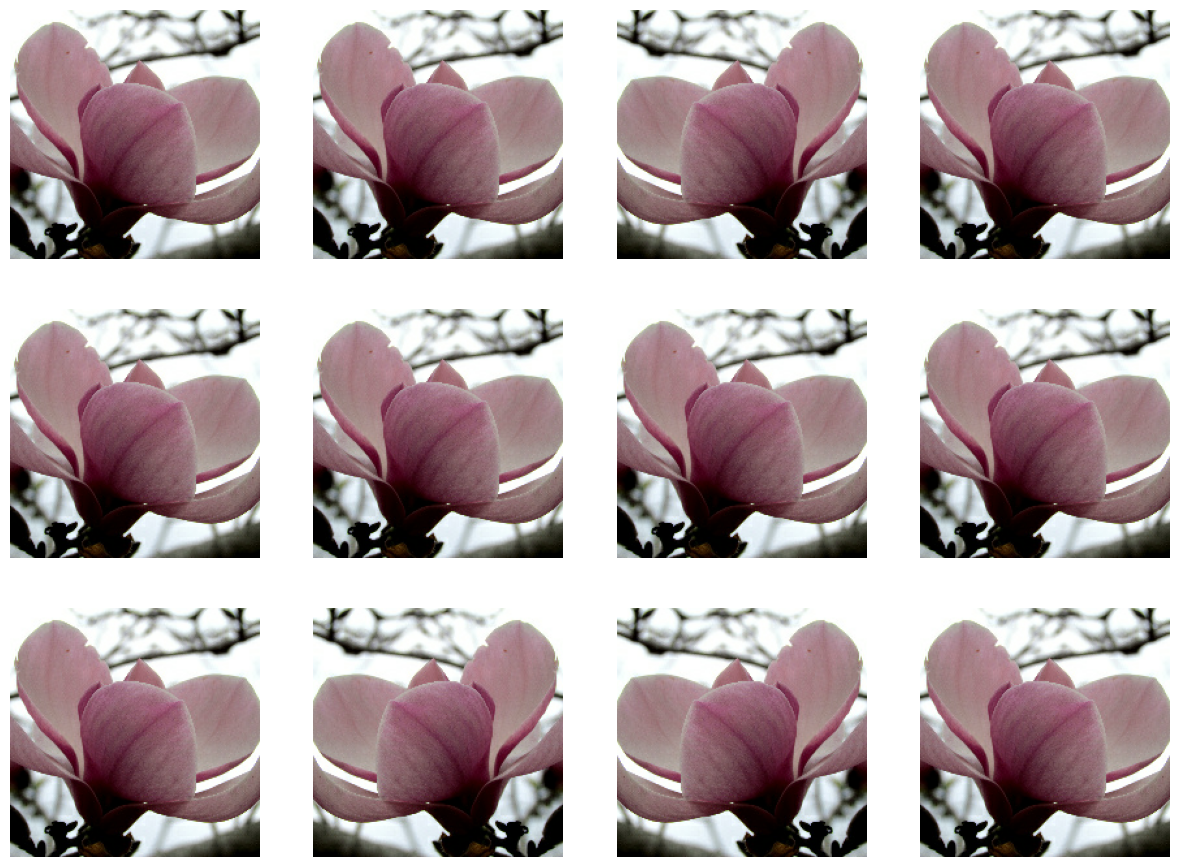

In [ ]:
row = 3
col = 4
all_elements = get_training_dataset().unbatch()
one_element = tf.data.Dataset.from_tensors(next(iter(all_elements)))
# Map the images to the data augmentation function for image processing
augmented_element = one_element.repeat().map(data_augment).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

In [ ]:
#tuning4
SEED = 2020

def random_blockout(img, sl=0.1, sh=0.2, rl=0.4):
    p=random.random()
    if p>=0.25:
        w, h, c = IMAGE_SIZE[0], IMAGE_SIZE[1], 3
        origin_area = tf.cast(h*w, tf.float32)

        e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
        e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

        e_height_h = tf.minimum(e_size_h, h)
        e_width_h = tf.minimum(e_size_h, w)

        erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
        erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

        erase_area = tf.zeros(shape=[erase_height, erase_width, c])
        erase_area = tf.cast(erase_area, tf.uint8)

        pad_h = h - erase_height
        pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
        pad_bottom = pad_h - pad_top

        pad_w = w - erase_width
        pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
        pad_right = pad_w - pad_left

        erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
        erase_mask = tf.squeeze(erase_mask, axis=0)
        erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

        return tf.cast(erased_img, img.dtype)
    else:
        return tf.cast(img, img.dtype)


def data_augment_v2(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the next function (below), this happens essentially for free on TPU.
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.

    flag = random.randint(1,3)
    coef_1 = random.randint(70, 90) * 0.01
    coef_2 = random.randint(70, 90) * 0.01

    if flag == 1:
        image = tf.image.random_flip_left_right(image, seed=SEED)
    elif flag == 2:
        image = tf.image.random_flip_up_down(image, seed=SEED)
    else:
        image = tf.image.random_crop(image, [int(IMAGE_SIZE[0]*coef_1), int(IMAGE_SIZE[0]*coef_2), 3],seed=SEED)

    image = random_blockout(image)

    return image, label

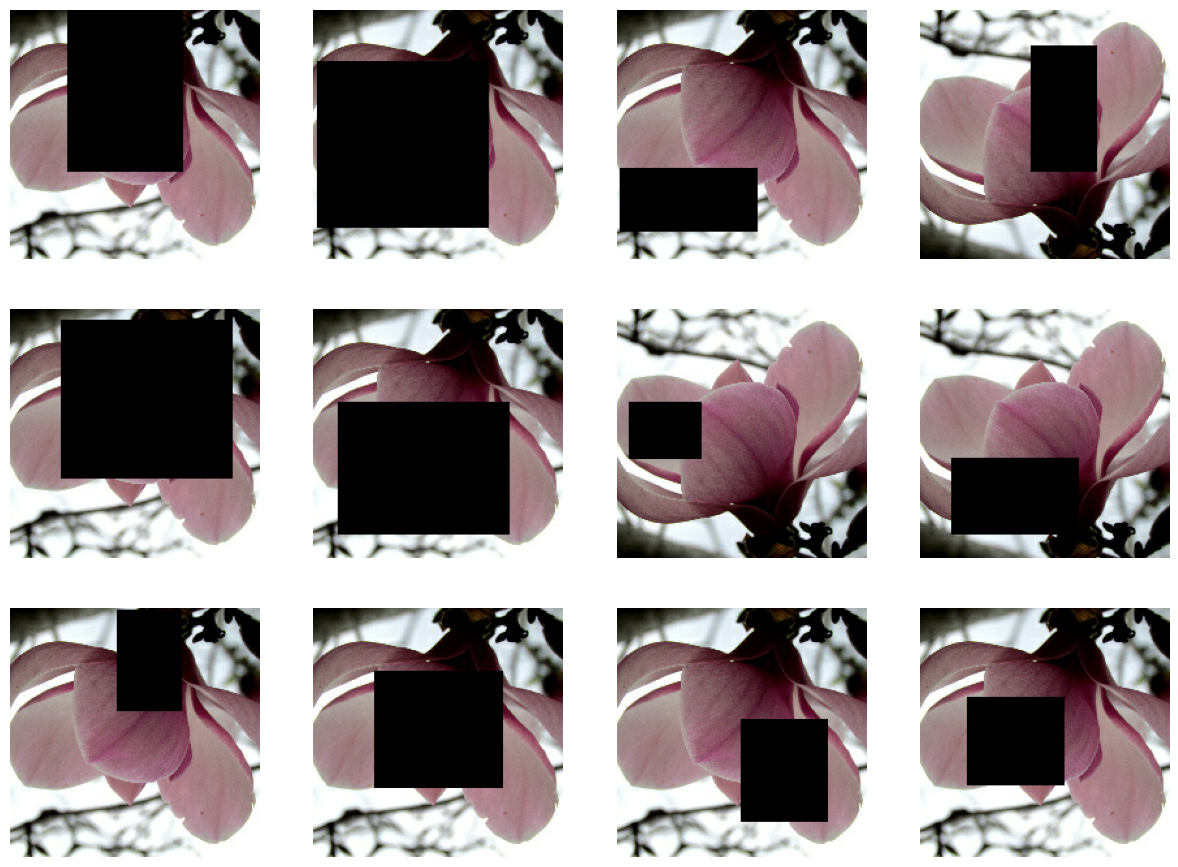

In [ ]:
augmented_element = one_element.repeat().map(data_augment_v2).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

In [ ]:
[*IMAGE_SIZE, 3]

[192, 192, 3]

In [ ]:
', '.join(tf.keras.applications.__dir__())

'__name__, __doc__, __package__, __loader__, __spec__, __path__, __file__, __cached__, __builtins__, convnext, densenet, efficientnet, efficientnet_v2, imagenet_utils, inception_resnet_v2, inception_v3, mobilenet, mobilenet_v2, mobilenet_v3, nasnet, regnet, resnet, resnet50, resnet_rs, resnet_v2, vgg16, vgg19, xception, ConvNeXtBase, ConvNeXtLarge, ConvNeXtSmall, ConvNeXtTiny, ConvNeXtXLarge, DenseNet121, DenseNet169, DenseNet201, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3, EfficientNetV2L, EfficientNetV2M, EfficientNetV2S, InceptionResNetV2, InceptionV3, MobileNet, MobileNetV2, MobileNetV3Large, MobileNetV3Small, NASNetLarge, NASNetMobile, RegNetX002, RegNetX004, RegNetX006, RegNetX008, RegNetX016, RegNetX032, RegNetX040, RegNetX064, RegNetX080, RegNetX120, RegNetX160, RegNetX320, RegNetY002, RegNetY004, RegNetY006, RegNetY008, Reg

In [ ]:
# Model weights are saved at the end of every epoch, if it's the best seen so far during model.fit
checkpoint_filepath = "Petals_to_the_Metal-70K_images-trainable_True-MobileNetV2.h5" #"Petals_to_the_Metal-70K_images-trainable_True-DenseNet201.h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
# This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
NotFoundError = """
class LRTensorBoard(TensorBoard):
    def __init__(self, log_dir, **kwargs):  # add other arguments to __init__ if you need
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super().on_epoch_end(epoch, logs)

lr_tracking = LRTensorBoard(log_dir="./lr_tracking")
"""

In [ ]:
class LearningRateTracking(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

        #logs = logs or {}
        #logs.update({'lr': K.eval(self.model.optimizer.lr)}) #optimizer._decayed_lr('float32').numpy()
        #return

#lr_tracking = LearningRateTracking()

In [ ]:
use_efficientnet = False #tuning9
if use_efficientnet:
    !pip install -q efficientnet
    from efficientnet.tfkeras import EfficientNetB7

In [ ]:
weight_per_class = True

if weight_per_class:
    from collections import Counter
    import gc

    gc.enable()

    def get_training_dataset_raw():
        dataset = load_dataset(TRAINING_FILENAMES, labeled = True, ordered = False)
        return dataset

    raw_training_dataset = get_training_dataset_raw()

    label_counter = Counter()
    for images, labels in raw_training_dataset:
        label_counter.update([labels.numpy()])

    del raw_training_dataset

    TARGET_NUM_PER_CLASS = 122 #?

    def get_weight_for_class(class_id):
        counting = label_counter[class_id]
        weight = TARGET_NUM_PER_CLASS / counting
        return weight

    weight_per_class = {class_id: get_weight_for_class(class_id) for class_id in range(104)}

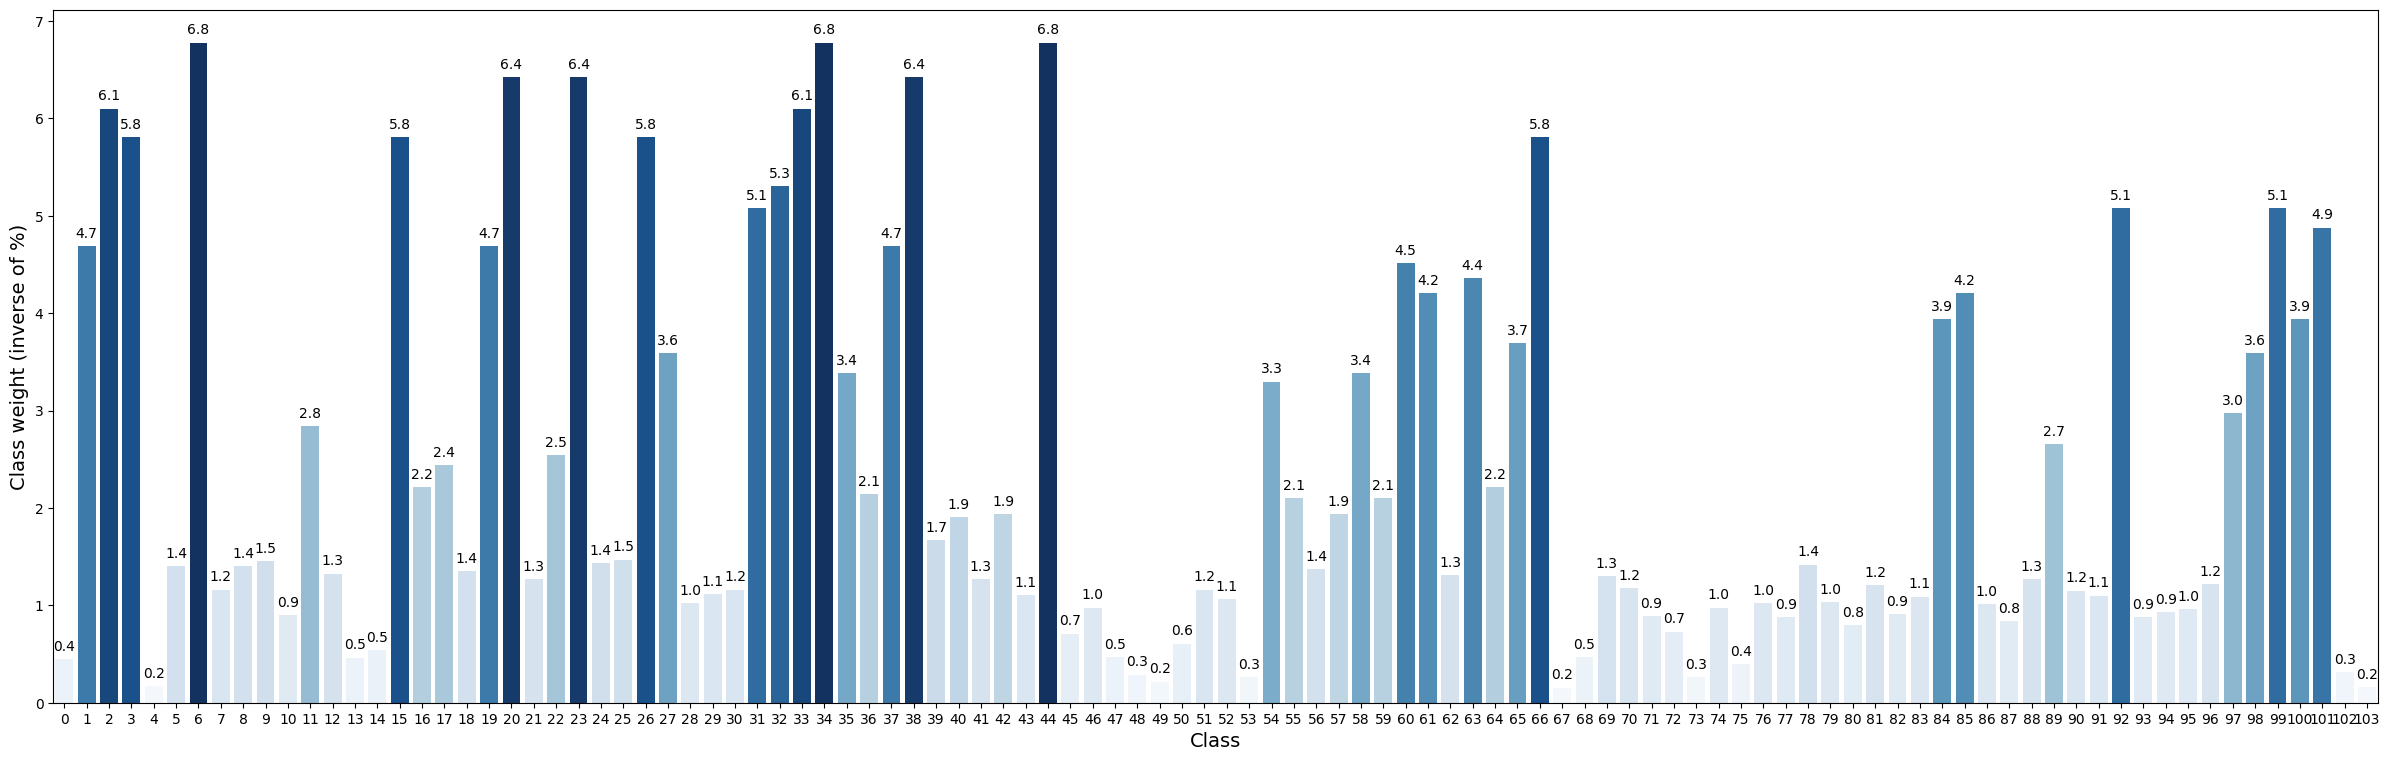

In [ ]:
if weight_per_class:
    data = pd.DataFrame.from_dict(weight_per_class, orient='index', columns=['class_weight'])
    plt.figure(figsize=(30, 9))

    #barplot color based on value
    bplot = sns.barplot(x=data.index, y='class_weight', data=data, palette= cm.Blues(data['class_weight']*0.15));
    for p in bplot.patches:
        bplot.annotate(format(p.get_height(), '.1f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')
    plt.xlabel("Class", size=14)
    plt.ylabel("Class weight (inverse of %)", size=14)

In [ ]:
using_ensemble_models = False

In [ ]:
if not using_ensemble_models:
    with strategy.scope():
        #pretrained_model = tf.keras.applications.VGG16
        #pretrained_model = tf.keras.applications.DenseNet201
        #pretrained_model = tf.keras.applications.InceptionResNetV2
        #pretrained_model = tf.keras.applications.InceptionV3
        #pretrained_model = tf.keras.applications.MobileNet
        #pretrained_model = tf.keras.applications.MobileNetV2
        #pretrained_model = tf.keras.applications.NASNetMobile
        #pretrained_model = tf.keras.applications.ResNet50
        #pretrained_model = tf.keras.applications.ResNet101V2
        #pretrained_model = tf.keras.applications.VGG19
        #pretrained_model = tf.keras.applications.Xception
        #pretrained_model = tf.keras.applications.DenseNet201
        #pretrained_model = EfficientNetB7

        pretrained_model = tf.keras.applications.MobileNetV2(
            include_top=False ,
            weights='imagenet', #tuning10 weights='noisy-student' instead of 'imagenet'
                                #Self-training with Noisy Student improves ImageNet classification https://arxiv.org/abs/1911.04252)
            #pooling='avg', #tuning1
            input_shape=[*IMAGE_SIZE, 3]
        )

        pretrained_model.trainable = True #tuning8 pretrained_model.trainable = True

        model = tf.keras.Sequential([
            pretrained_model, #Base pretrained on ImageNet to extract features from images

            tf.keras.layers.GlobalAveragePooling2D(), ##Attach a new head to act as a classifier
            #tf.keras.layers.Dropout(0.3), #tuning3
            tf.keras.layers.Dense(len(CLASSES), activation='softmax')
        ])

9406464/9406464 [==============================] - 3s 0us/step


In [ ]:
if not using_ensemble_models:
    model.compile(
        optimizer='nadam', #tuning2 optimizer='nadam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

In [ ]:
if not using_ensemble_models:
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 104)               133224    
                                                                 
Total params: 2391208 (9.12 MB)
Trainable params: 2357096 (8.99 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


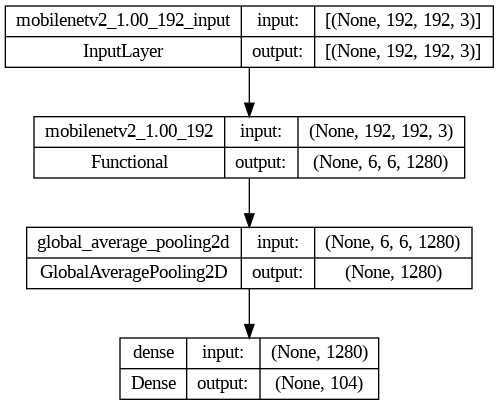

In [ ]:
#if not using_ensemble_models:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
if not using_ensemble_models:
    # Define training epochs
    EPOCHS = 30

    # Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync #See Note 3.1 above 😀

    STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

Learning rate schedule: 1e-05 to 5e-05 to 1e-05


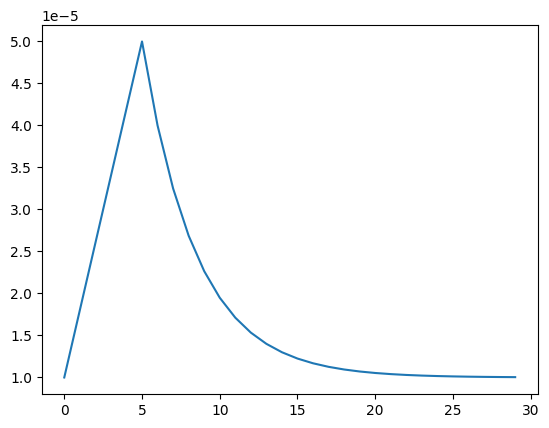

In [ ]:
if not using_ensemble_models:
    # Learning Rate Schedule for Fine Tuning #
    def exponential_lr(epoch,
                       start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005 * strategy.num_replicas_in_sync, #tuning1
                       rampup_epochs = 5, sustain_epochs = 0,
                       exp_decay = 0.75): #tuning1

        def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
            # linear increase from start to rampup_epochs
            if epoch < rampup_epochs:
                lr = ((max_lr - start_lr) /
                      rampup_epochs * epoch + start_lr)
            # constant max_lr during sustain_epochs
            elif epoch < rampup_epochs + sustain_epochs:
                lr = max_lr
            # exponential decay towards min_lr
            else:
                lr = ((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                      min_lr)
            return lr
        return lr(epoch,
                  start_lr,
                  min_lr,
                  max_lr,
                  rampup_epochs,
                  sustain_epochs,
                  exp_decay)

    lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

    rng = [i for i in range(EPOCHS)]
    y = [exponential_lr(x) for x in rng]
    plt.plot(rng, y)
    print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
if not using_ensemble_models:
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[lr_callback, checkpoint], # Model weights are saved at the end of every epoch, if it's the best seen so far
        #workers = 3 #tuning5 https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras
        class_weight = weight_per_class #tuning11
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
797/797 [==============================] - 1789s 2s/step - loss: 2.9932 - sparse_categorical_accuracy: 0.2535 - val_loss: 19.9636 - val_sparse_categorical_accuracy: 0.0102 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/30
797/797 [==============================] - 1542s 2s/step - loss: 1.5872 - sparse_categorical_accuracy: 0.4861 - val_loss: 5.2141 - val_sparse_categorical_accuracy: 0.2101 - lr: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/30
797/797 [==============================] - 1544s 2s/step - loss: 0.9144 - sparse_categorical_accuracy: 0.6539 - val_loss: 3.0694 - val_sparse_categorical_accuracy: 0.4410 - lr: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/30
797/797 [==============================] - 1563s 2s/step - loss: 0.5267 - 

In [ ]:
if not using_ensemble_models:
    display_training_curves_v2(
        history.history['loss'],
        history.history['val_loss'],
        history.history['lr'],
        'loss',
        211,
    )

    display_training_curves_v2(
        history.history['sparse_categorical_accuracy'],
        history.history['val_sparse_categorical_accuracy'],
        history.history['lr'],
        'accuracy',
        212,
    )

In [ ]:
zoom_after = 20
if not using_ensemble_models:
    display_training_curves(
        history.history['loss'][zoom_after:],
        history.history['val_loss'][zoom_after:],
        'loss',
        211,
    )

    display_training_curves(
        history.history['sparse_categorical_accuracy'][zoom_after:],
        history.history['val_sparse_categorical_accuracy'][zoom_after:],
        'accuracy',
        212,
    )

In [ ]:
checkpoint_filepath

In [ ]:
if not using_ensemble_models:
    model.load_weights(checkpoint_filepath)

In [ ]:
model.summary()

In [ ]:
print(checkpoint_filepath)
tflite_model_name = checkpoint_filepath.replace('.h5', '.tflite')
tflite_model_name

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open(tflite_model_name, 'wb') as f:
    f.write(tflite_model)

print('TFLiteConversion completed successfully \U0001F680')

In [ ]:
def get_pretrained_model(model_name, image_dataset_weights, trainable=True):
    pretrained_model= model_name(
        include_top=False ,
        weights=image_dataset_weights, #tuning10 weights='noisy-student' instead of 'imagenet'
                                       #Self-training with Noisy Student improves ImageNet classification https://arxiv.org/abs/1911.04252)
        input_shape=[*IMAGE_SIZE, 3]
    )

    pretrained_model.trainable = trainable #tuning8 pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

    return model

In [ ]:
if using_ensemble_models:
    with strategy.scope():
        model_EB7 = get_pretrained_model(EfficientNetB7, 'noisy-student', trainable=True)

    model_EB7.load_weights('../input/models/Petals_to_the_Metal-70K_images-trainable_True-EfficientNetB7.h5')

In [ ]:
if using_ensemble_models:
    model_EB7.summary()

In [ ]:
if using_ensemble_models:
    with strategy.scope():
        model_D201 = get_pretrained_model(tf.keras.applications.DenseNet201, 'imagenet', trainable=True)

    model_D201.load_weights('../input/models/Petals_to_the_Metal-70K_images-trainable_True-DenseNet201.h5')

In [ ]:
if using_ensemble_models:
    model_D201.summary()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
if using_ensemble_models:
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch

    m1 = model_EB7.predict(images_ds)
    m2 = model_D201.predict(images_ds)

    scores = []
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha*m1+(1-alpha)*m2
        cm_predictions = np.argmax(cm_probabilities, axis=-1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)
    plt.plot(scores)

    best_alpha = np.argmax(scores)/100
    cm_probabilities = best_alpha*m1+(1-best_alpha)*m2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)

    #best_alpha = 0.35

In [ ]:
if using_ensemble_models:
    print(best_alpha, max(scores))

In [ ]:
if using_ensemble_models:
    test_ds = get_test_dataset(ordered=True)
    #best_alpha = 0.35

    print('Computing predictions...')
    test_images_ds = test_ds.map(lambda image, idnum: image)
    probabilities1 = model_EB7.predict(test_images_ds)
    probabilities2 = model_D201.predict(test_images_ds)

    probabilities = best_alpha * probabilities1 + (1 - best_alpha) * probabilities2

    predictions = np.argmax(probabilities, axis=-1)
    print(predictions)

    print('Generating submission.csv file...')
    # Get image ids from test set and convert to unicode
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

    # Write the submission file
    np.savetxt(
        'submission.csv',
        np.rec.fromarrays([test_ids, predictions]),
        fmt=['%s', '%d'],
        delimiter=',',
        header='id,label',
        comments='',
    )

    # Look at the first few predictions
    !head submission.csv

In [ ]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(25,25))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})

    if not using_ensemble_models:
        print('Epoch with min loss and max accuracy:', np.argmin(history.history['val_loss']), np.argmax(history.history['val_sparse_categorical_accuracy']))
        print('min loss and max accuracy:', round(min(history.history['val_loss']),2), round(max(history.history['val_sparse_categorical_accuracy']),2))

    print(titlestring.replace('\n', ''))
    plt.show()

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()

if using_ensemble_models:
    print('using_ensemble_models')
    probabilities1 = model_EB7.predict(images_ds)
    probabilities2 = model_D201.predict(images_ds)
    cm_probabilities = best_alpha * probabilities1 + (1 - best_alpha) * probabilities2
else:
    cm_probabilities = model.predict(images_ds)

cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

In [ ]:
cmat

In [ ]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)

precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)

recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)

display_confusion_matrix(cmat, score, precision, recall)

In [ ]:
model_performance_report = pd.DataFrame(columns=['model-family', 'model', 'epochs', 'arg min loss', 'arg max accuracy',
                                                 'min loss', 'max accuracy', 'f1', 'precision', 'recall'])

model_performance_report.loc[len(model_performance_report)]={ 'model-family': 'VGG',
                                                              'model':'VGG16',
                                                              'epochs':12,
                                                              'arg min loss':11,
                                                              'arg max accuracy':11,
                                                              'min loss':3.47,
                                                              'max accuracy':0.23,
                                                              'f1':0.123,
                                                              'precision':0.146,
                                                              'recall':0.226}

model_performance_report.loc[len(model_performance_report)]={ 'model-family': 'DenseNet',
                                                              'model':'DenseNet201',
                                                              'epochs':12,
                                                              'arg min loss':11,
                                                              'arg max accuracy':10,
                                                              'min loss':1.31,
                                                              'max accuracy':0.74,
                                                              'f1':0.643,
                                                              'precision':0.761,
                                                              'recall':0.599}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'InceptionResNet',
                                                              'model':'InceptionResNetV2',
                                                              'epochs':12,
                                                              'arg min loss':11,
                                                              'arg max accuracy':11,
                                                              'min loss':1.57,
                                                              'max accuracy':0.66,
                                                              'f1':0.513,
                                                              'precision':0.640,
                                                              'recall':0.480}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'Inception',
                                                              'model':'InceptionV3',
                                                              'epochs':12,
                                                              'arg min loss':11,
                                                              'arg max accuracy':11,
                                                              'min loss':1.48,
                                                              'max accuracy':0.69,
                                                              'f1':0.581,
                                                              'precision':0.728,
                                                              'recall':0.538}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'MobileNet',
                                                              'model':'MobileNet',
                                                              'epochs':12,
                                                              'arg min loss':11,
                                                              'arg max accuracy':10,
                                                              'min loss':1.11,
                                                              'max accuracy':0.76,
                                                              'f1':0.717,
                                                              'precision':0.798,
                                                              'recall':0.679}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'MobileNet',
                                                              'model':'MobileNetV2',
                                                              'epochs':12,
                                                              'arg min loss':11,
                                                              'arg max accuracy':11,
                                                              'min loss':1.26,
                                                              'max accuracy':0.72,
                                                              'f1':0.650,
                                                              'precision':0.763,
                                                              'recall':0.606}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'NASNetMobile',
                                                              'model':'NASNetMobile',
                                                              'epochs':12,
                                                              'arg min loss':11,
                                                              'arg max accuracy':11,
                                                              'min loss':2.69,
                                                              'max accuracy':0.38,
                                                              'f1':0.224,
                                                              'precision':0.401,
                                                              'recall':0.203}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'ResNet',
                                                              'model':'ResNet50',
                                                              'epochs':12,
                                                              'arg min loss':11,
                                                              'arg max accuracy':11,
                                                              'min loss':3.85,
                                                              'max accuracy':0.12,
                                                              'f1':0.017,
                                                              'precision':0.035,
                                                              'recall':0.025}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'ResNet',
                                                              'model':'R101V2',
                                                              'epochs':12,
                                                              'arg min loss':11,
                                                              'arg max accuracy':9,
                                                              'min loss':0.87,
                                                              'max accuracy':0.83,
                                                              'f1':0.775,
                                                              'precision':0.842,
                                                              'recall':0.741}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'VGG',
                                                              'model':'VGG19',
                                                              'epochs':12,
                                                              'arg min loss':11,
                                                              'arg max accuracy':11,
                                                              'min loss':3.58,
                                                              'max accuracy':0.21,
                                                              'f1':0.031,
                                                              'precision':0.036,
                                                              'recall':0.048}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'Xception',
                                                              'model':'Xception',
                                                              'epochs':12,
                                                              'arg min loss':11,
                                                              'arg max accuracy':11,
                                                              'min loss':1.43,
                                                              'max accuracy':0.71,
                                                              'f1':0.575,
                                                              'precision':0.712,
                                                              'recall':0.536}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'ResNet',
                                                              'model':'R2 30e',
                                                              'epochs':30,
                                                              'arg min loss':29,
                                                              'arg max accuracy':28,
                                                              'min loss':0.83,
                                                              'max accuracy':0.83,
                                                              'f1':0.788,
                                                              'precision':0.863,
                                                              'recall':0.753}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'ResNet',
                                                              'model':'R101V2 1,2,3+OF',
                                                              'epochs':30,
                                                              'arg min loss':26,
                                                              'arg max accuracy':27,
                                                              'min loss':0.52,
                                                              'max accuracy':0.88,
                                                              'f1':0.864,
                                                              'precision':0.916,
                                                              'recall':0.842}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'DenseNet',
                                                              'model':'D 1,2',
                                                              'epochs':30,
                                                              'arg min loss':29,
                                                              'arg max accuracy':29,
                                                              'min loss':0.92,
                                                              'max accuracy':0.81,
                                                              'f1':0.767,
                                                              'precision':0.833,
                                                              'recall':0.732}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'DenseNet',
                                                              'model':'D201 1,2,4',
                                                              'epochs':30,
                                                              'arg min loss':29,
                                                              'arg max accuracy':27,
                                                              'min loss':0.92,
                                                              'max accuracy':0.82,
                                                              'f1':0.772,
                                                              'precision':0.846,
                                                              'recall':0.734}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'ResNet',
                                                              'model':'R101V2 1,2,4',
                                                              'epochs':30,
                                                              'arg min loss':29,
                                                              'arg max accuracy':28,
                                                              'min loss':0.66,
                                                              'max accuracy':0.85,
                                                              'f1':0.829,
                                                              'precision':0.870,
                                                              'recall':0.802}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'ResNet',
                                                              'model':'R101V2 1,2,4,5',
                                                              'epochs':30,
                                                              'arg min loss':29,
                                                              'arg max accuracy':23,
                                                              'min loss':0.66,
                                                              'max accuracy':0.86,
                                                              'f1':0.829,
                                                              'precision':0.883,
                                                              'recall':0.802}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'DenseNet',
                                                              'model':'D 1,8',
                                                              'epochs':30,
                                                              'arg min loss':26,
                                                              'arg max accuracy':28,
                                                              'min loss':0.23,
                                                              'max accuracy':0.95,
                                                              'f1':0.945,
                                                              'precision':0.950,
                                                              'recall':0.946}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'ResNet',
                                                              'model':'R101V2 1,8',
                                                              'epochs':30,
                                                              'arg min loss':10,
                                                              'arg max accuracy':16,
                                                              'min loss':0.36,
                                                              'max accuracy':0.92,
                                                              'f1':0.909,
                                                              'precision':0.913,
                                                              'recall':0.911}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'ResNet',
                                                              'model':'D 1,2,8',
                                                              'epochs':30,
                                                              'arg min loss':10,
                                                              'arg max accuracy':11,
                                                              'min loss':0.21,
                                                              'max accuracy':0.95,
                                                              'f1':0.953,
                                                              'precision':0.960,
                                                              'recall':0.950}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'EfficientNet',
                                                              'model':'EB7 1,2,9,10',
                                                              'epochs':30,
                                                              'arg min loss':29,
                                                              'arg max accuracy':27,
                                                              'min loss':0.73,
                                                              'max accuracy':0.84,
                                                              'f1':0.779,
                                                              'precision':0.839,
                                                              'recall':0.755}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'EfficientNet',
                                                              'model':'EB7 +11',
                                                              'epochs':30,
                                                              'arg min loss':29,
                                                              'arg max accuracy':28,
                                                              'min loss':1.0,
                                                              'max accuracy':0.81,
                                                              'f1':0.775,
                                                              'precision':0.769,
                                                              'recall':0.821}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'EfficientNet',
                                                              'model':'EB7 1,2,8,9,10,11',
                                                              'epochs':30,
                                                              'arg min loss':15,
                                                              'arg max accuracy':18,
                                                              'min loss':0.25,
                                                              'max accuracy':0.96,
                                                              'f1':0.955,
                                                              'precision':0.950,
                                                              'recall':0.964}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'ResNet',
                                                              'model':'D 1,2,8,11',
                                                              'epochs':30,
                                                              'arg min loss':24,
                                                              'arg max accuracy':23,
                                                              'min loss':0.22,
                                                              'max accuracy':0.95,
                                                              'f1':0.956,
                                                              'precision':0.957,
                                                              'recall':0.958}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'Ensemble',
                                                              'model':'Ensemble EB7+D201',
                                                              'epochs':30,
                                                              'arg min loss':24,
                                                              'arg max accuracy':23,
                                                              'min loss':0.22,
                                                              'max accuracy':0.95,
                                                              'f1':0.962,
                                                              'precision':0.960,
                                                              'recall':0.966}

extra_columns = ['total params', 'trainable params', 'non-trainable params','training time per epoch (sec)']
model_performance_report[extra_columns] = pd.DataFrame([[np.nan, np.nan, np.nan, np.nan]], index=model_performance_report.index)

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'DenseNet',
                                                              'model':'D 1,2,6',
                                                              'total params':18_521_768,
                                                              'trainable params':199_784,
                                                              'non-trainable params':18_321_984,
                                                              'training time per epoch (sec)':114,
                                                              'epochs':30,
                                                              'arg min loss':29,
                                                              'arg max accuracy':29,
                                                              'min loss':0.71,
                                                              'max accuracy':0.85,
                                                              'f1':0.826,
                                                              'precision':0.791,
                                                              'recall':0.890}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'DenseNet',
                                                              'model':'D 1,2,6,12',
                                                              'total params':18_521_768,
                                                              'trainable params':199_784,
                                                              'non-trainable params':18_321_984,
                                                              'training time per epoch (sec)':114,
                                                              'epochs':30,
                                                              'arg min loss':29,
                                                              'arg max accuracy':29,
                                                              'min loss':0.71,
                                                              'max accuracy':0.85,
                                                              'f1':0.826,
                                                              'precision':0.791,
                                                              'recall':0.890}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'DenseNet',
                                                              'model':'D 1,2,6,8',
                                                              'total params':18_521_768,
                                                              'trainable params':18_292_712,
                                                              'non-trainable params':229_056,
                                                              'training time per epoch (sec)':274,
                                                              'epochs':30,
                                                              'arg min loss':26,
                                                              'arg max accuracy':28,
                                                              'min loss':0.22,
                                                              'max accuracy':0.96,
                                                              'f1':0.948,
                                                              'precision':0.942,
                                                              'recall':0.957}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'DenseNet',
                                                              'model':'D 1,2,6,8,12',
                                                              'total params':18_521_768,
                                                              'trainable params':18_292_712,
                                                              'non-trainable params':229_056,
                                                              'training time per epoch (sec)':274,
                                                              'epochs':30,
                                                              'arg min loss':26,
                                                              'arg max accuracy':28,
                                                              'min loss':0.22,
                                                              'max accuracy':0.96,
                                                              'f1':0.948,
                                                              'precision':0.942,
                                                              'recall':0.957}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'EfficientNet',
                                                              'model':'EB7 1,2,6,8,9,10,11',
                                                              'total params':64_364_024,
                                                              'trainable params':64_053_304,
                                                              'non-trainable params':310_720,
                                                              'training time per epoch (sec)':511,
                                                              'epochs':30,
                                                              'arg min loss':20,
                                                              'arg max accuracy':28,
                                                              'min loss':0.24,
                                                              'max accuracy':0.96,
                                                              'f1':0.956,
                                                              'precision':0.949,
                                                              'recall':0.967}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'Ensemble',
                                                              'model':'Ensemble 6,12 EB7+D201',
                                                              'total params':82_885_792,
                                                              'trainable params':82_346_016,
                                                              'non-trainable params':539_776,
                                                              'training time per epoch (sec)':785,
                                                              'epochs':30,
                                                              'arg min loss':20,
                                                              'arg max accuracy':28,
                                                              'min loss':0.24,
                                                              'max accuracy':0.96,
                                                              'f1':0.962,
                                                              'precision':0.956,
                                                              'recall':0.971}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'MobileNet',
                                                              'model':'MobileNetV2 1,2,6',
                                                              'total params':2_391_208,
                                                              'trainable params':133_224,
                                                              'non-trainable params':2_257_984,
                                                              'training time per epoch (sec)':79,
                                                              'epochs':30,
                                                              'arg min loss':29,
                                                              'arg max accuracy':26,
                                                              'min loss':0.83,
                                                              'max accuracy':0.8,
                                                              'f1':0.781,
                                                              'precision':0.752,
                                                              'recall':0.850}

model_performance_report.loc[len(model_performance_report)]={ 'model-family':'MobileNet',
                                                              'model':'MobileNetV2 1,2,6,8',
                                                              'total params':2_391_208,
                                                              'trainable params':2_357_096,
                                                              'non-trainable params':34_112,
                                                              'training time per epoch (sec)':102,
                                                              'epochs':30,
                                                              'arg min loss':24,
                                                              'arg max accuracy':27,
                                                              'min loss':0.27,
                                                              'max accuracy':0.95,
                                                              'f1':0.936,
                                                              'precision':0.929,
                                                              'recall':0.951}

In [ ]:
model_performance_report

In [ ]:
#sns.set_theme(style="white")

# Plot miles per gallon against horsepower with other semantics
with sns.axes_style("whitegrid", {'grid.linestyle': '--'}):
    myplot = sns.relplot(x="model", y="max accuracy", hue="model", size="f1",
                sizes=(100, 1000), alpha=1, palette="pastel", legend="brief", #, “brief”, “full”, or False
                height=15, data=model_performance_report)

#myplot.fig.set_size_inches(25,15)

#Slighlty rotate the x-axis labels so model names to not overlap
myplot.set_xticklabels(rotation=45)

#Add yaxis gridlines
myplot.axes[0][0].set_yticks(np.arange(0,1.05,0.05), minor=False)

#For each model, add model name, val accuracy and f1 score
df = model_performance_report.copy()
for line in range(0,df.shape[0]):
    if df['model'][line] in ['D 1,8', 'D 1,2,8', 'D 1,2,6', 'D 1,2,6,12', 'D 1,2,6,8', 'D 1,2,6,8,12', 'D 1,2,8,11', 'R101V2', 'EB7 1,2,6,8,9,10,11']:
        #print(df['model'][line])
        mytext = str(df['model'][line][0]) #+' '+str(df['max accuracy'][line])+' '+str(df['f1'][line])
    else:
        mytext = str(df['model'][line])+' - acc:'+str(df['max accuracy'][line])+' - f1:'+str(df['f1'][line])

    myplot.axes[0,0].text(model_performance_report['model'][line],
                           df['max accuracy'][line],
                           mytext,
                           horizontalalignment='left',
                           size='medium',
                           color='black',
                           weight='normal')

#Add title and rename axes
myplot.set(title='Petals to the Metal - Model Performance - y axis:val acc, size:f1 score - Milestones: 12 epochs; 30 epochs; Hyperparameter tuning; End to end training; Ensemble models; 5x data; Ensemble models of 5x models', xlabel='Model', ylabel='Validation Accuracy')

#Add annotation for training from scratch models
x_location, y_location = 10, 0.97
myplot.axes[0][0].annotate('End to end training (tuning8)', xy=(x_location+6, y_location), xytext=(x_location, y_location+0.01),
             arrowprops=dict(facecolor='#C4F0EF', shrink=0.05, headwidth=20, width=5))

#Add annotation for Transfer Learning with tuning models
x_location, y_location = 1, 0.85
myplot.axes[0][0].annotate('Transfer Learning with tuning for 30 epochs', xy=(x_location+9, y_location), xytext=(x_location, y_location+0.01),
             arrowprops=dict(facecolor='#F5B78A', shrink=0.05, headwidth=20, width=5))

#Add annotation for transfer learning models
x_location, y_location = 5, 0.23
myplot.axes[0][0].annotate('Transfer Learning for 12 epochs', xy=(x_location-2, y_location-0.03), xytext=(x_location, y_location-0.05),
             arrowprops=dict(facecolor='lightgrey', shrink=0.05, headwidth=20, width=5))

#Add annotation for transfer learning models
x_location, y_location = -1.5, 0.8
myplot.axes[0][0].annotate('Transfer Learning for 12 epochs', xy=(x_location+6, y_location), xytext=(x_location, y_location+0.01),
             arrowprops=dict(facecolor='#FFFDAE', shrink=0.05, headwidth=20, width=5))

#Add annotation for Ensemble EB7+D201
x_location, y_location = 19, 0.97
myplot.axes[0][0].annotate('Ensemble EB7+D201', xy=(x_location+5, y_location-0.0005), xytext=(x_location, y_location+0.01),
             arrowprops=dict(facecolor='#CCBDFA', shrink=0.05, headwidth=20, width=5))

#Add annotation for 70K (5x) additional data
x_location, y_location = 22, 0.98
myplot.axes[0][0].annotate('Additional data 70K (5x)', xy=(x_location+5, y_location-0.01), xytext=(x_location, y_location+0.01),
             arrowprops=dict(facecolor='lightgrey', shrink=0.05, headwidth=20, width=5))

#Add annotation for Legend and
x_location, y_location = 15, 0.1
myplot.axes[0][0].annotate('Models sorted chronologically, size:f1 score', xy=(x_location+12, y_location), xytext=(x_location, y_location),
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=5))

#Add Tuning Legend
x_location, y_location, y_delta = 15.1, 0.655, 0.03
myplot.axes[0][0].annotate('Author: George Zoto', xy=(x_location, y_location+y_delta), size='x-large')
myplot.axes[0][0].annotate('Tuning Legend, models sorted chronologically', xy=(x_location, y_location), size='x-large')
myplot.axes[0][0].annotate('tuning1: pooling=avg, exponential_lr()', xy=(x_location, y_location-y_delta), size='large')
myplot.axes[0][0].annotate('tuning2: optimizer=nadam', xy=(x_location, y_location-2*y_delta), size='large')
myplot.axes[0][0].annotate('tuning3: Dropout(0.3)', xy=(x_location, y_location-3*y_delta), size='large')
myplot.axes[0][0].annotate('tuning4: data_augment_v2 with random_blockout', xy=(x_location, y_location-4*y_delta), size='large')
myplot.axes[0][0].annotate('tuning5: workers = 3 Multi-worker training with Keras', xy=(x_location, y_location-5*y_delta), size='large')
myplot.axes[0][0].annotate('tuning6: additional data', xy=(x_location, y_location-6*y_delta), size='large')
myplot.axes[0][0].annotate('tuning7: data_augment_v3', xy=(x_location, y_location-7*y_delta), size='large')
myplot.axes[0][0].annotate('tuning8: pretrained_model.trainable=True', xy=(x_location, y_location-8*y_delta), size='large')
myplot.axes[0][0].annotate('tuning9: EfficientNetB7', xy=(x_location, y_location-9*y_delta), size='large')
myplot.axes[0][0].annotate('tuning10: noisy-student', xy=(x_location, y_location-10*y_delta), size='large')
myplot.axes[0][0].annotate('tuning11: weight_per_class', xy=(x_location, y_location-11*y_delta), size='large');
myplot.axes[0][0].annotate('tuning12: Test Time Augmentation TTA', xy=(x_location, y_location-12*y_delta), size='large');

In [ ]:
model_performance_report = model_performance_report.sort_values(by='max accuracy')
model_performance_report

In [ ]:
#sns.set_theme(style="white")

# Plot miles per gallon against horsepower with other semantics
with sns.axes_style("whitegrid", {'grid.linestyle': '--'}):
    myplot = sns.relplot(x="model", y="max accuracy", hue="model", size="f1",
                sizes=(100, 1000), alpha=1, palette="pastel", legend="brief", #, “brief”, “full”, or False
                height=15, data=model_performance_report)

#myplot.fig.set_size_inches(25,15)

#Slighlty rotate the x-axis labels so model names to not overlap
myplot.set_xticklabels(rotation=70)

#Add yaxis gridlines
myplot.axes[0][0].set_yticks(np.arange(0,1.05,0.05), minor=False)

#For each model, add model name, val accuracy and f1 score
df = model_performance_report.copy()
for line in range(0,df.shape[0]):
    if df['model'][line] in ['D 1,2', 'D 1,8', 'D 1,2,6', 'D 1,2,6,12', 'D 1,2,6,8', 'D 1,2,6,8,12', 'D 1,2,8', 'D 1,2,8,11', 'R101V2', 'EB7 1,2,8,9,10,11', 'EB7 1,2,6,8,9,10,11', 'Ensemble EB7+D201', 'MobileNetV2 1,2,6,8']:
        #print(df['model'][line])
        mytext = str(df['model'][line][0])#+' '+str(df['max accuracy'][line])+' '+str(df['f1'][line])
    else:
        mytext = str(df['model'][line])+' - acc:'+str(df['max accuracy'][line])+' - f1:'+str(df['f1'][line])

    myplot.axes[0,0].text(model_performance_report['model'][line],
                           df['max accuracy'][line],
                           mytext,
                           horizontalalignment='left',
                           size='medium',
                           color='black',
                           weight='normal')

#Add title and rename axes
myplot.set(title='Petals to the Metal - Model Performance - y axis:val acc, size:f1 score - Milestones: 12 epochs; 30 epochs; Hyperparameter tuning; End to end training; Ensemble models; 5x data; Ensemble models of 5x models', xlabel='Model', ylabel='Validation Accuracy')

#Add annotation for training from scratch models
x_location, y_location = 14, 0.93
myplot.axes[0][0].annotate('End to end training (tuning8)', xy=(x_location+7, y_location), xytext=(x_location, y_location+0.01),
             arrowprops=dict(facecolor='#a0e2a7', shrink=0.05, headwidth=20, width=5))

#Add annotation for Transfer Learning with tuning models
x_location, y_location = 4, 0.85
myplot.axes[0][0].annotate('Transfer Learning with tuning for 30 epochs', xy=(x_location+9, y_location), xytext=(x_location, y_location+0.01),
             arrowprops=dict(facecolor='#CCBDFA', shrink=0.05, headwidth=20, width=5))

#Add annotation for transfer learning models
x_location, y_location = 5, 0.23
myplot.axes[0][0].annotate('Transfer Learning for 12 epochs', xy=(x_location-2, y_location-0.03), xytext=(x_location, y_location-0.05),
             arrowprops=dict(facecolor='lightgrey', shrink=0.05, headwidth=20, width=5))

#Add annotation for transfer learning models
x_location, y_location = 0, 0.75
myplot.axes[0][0].annotate('Transfer Learning for 12 epochs', xy=(x_location+7, y_location), xytext=(x_location, y_location+0.01),
             arrowprops=dict(facecolor='lightgrey', shrink=0.05, headwidth=20, width=5))

#Add annotation for Ensemble EB7+D201
x_location, y_location = 19, 0.96
myplot.axes[0][0].annotate('Ensemble EB7+D201', xy=(x_location+5, y_location-0.001), xytext=(x_location, y_location+0.01),
             arrowprops=dict(facecolor='#ccbdfa', shrink=0.05, headwidth=20, width=5))

#Add annotation for 70K (5x) additional data
x_location, y_location = 21.5, 0.975
myplot.axes[0][0].annotate('Additional data 70K (5x)', xy=(x_location+5.5, y_location-0.005), xytext=(x_location, y_location+0.01),
             arrowprops=dict(facecolor='lightgrey', shrink=0.05, headwidth=20, width=5))

#Add annotation for Ensemble 6,12 EB7+D201
x_location, y_location = 26.5, 0.985
myplot.axes[0][0].annotate('Ensemble 6,12 EB7+D201', xy=(x_location+5.5, y_location-0.01), xytext=(x_location, y_location+0.01),
             arrowprops=dict(facecolor='#a0e2a7', shrink=0.05, headwidth=20, width=5))

#Add annotation for Legend and
x_location, y_location = 15, 0.1
myplot.axes[0][0].annotate('Models sorted by val accuracy, size:f1 score', xy=(x_location+12, y_location), xytext=(x_location, y_location),
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=5))

#Add Tuning Legend
x_location, y_location, y_delta = 15.1, 0.655, 0.03
myplot.axes[0][0].annotate('Author: George Zoto', xy=(x_location, y_location+y_delta), size='x-large')
myplot.axes[0][0].annotate('Tuning Legend, models sorted by performance', xy=(x_location, y_location), size='x-large')
myplot.axes[0][0].annotate('tuning1: pooling=avg, exponential_lr()', xy=(x_location, y_location-y_delta), size='large')
myplot.axes[0][0].annotate('tuning2: optimizer=nadam', xy=(x_location, y_location-2*y_delta), size='large')
myplot.axes[0][0].annotate('tuning3: Dropout(0.3)', xy=(x_location, y_location-3*y_delta), size='large')
myplot.axes[0][0].annotate('tuning4: data_augment_v2 with random_blockout', xy=(x_location, y_location-4*y_delta), size='large')
myplot.axes[0][0].annotate('tuning5: workers = 3 Multi-worker training with Keras', xy=(x_location, y_location-5*y_delta), size='large')
myplot.axes[0][0].annotate('tuning6: additional data', xy=(x_location, y_location-6*y_delta), size='large')
myplot.axes[0][0].annotate('tuning7: data_augment_v3', xy=(x_location, y_location-7*y_delta), size='large')
myplot.axes[0][0].annotate('tuning8: pretrained_model.trainable=True', xy=(x_location, y_location-8*y_delta), size='large')
myplot.axes[0][0].annotate('tuning9: EfficientNetB7', xy=(x_location, y_location-9*y_delta), size='large')
myplot.axes[0][0].annotate('tuning10: noisy-student', xy=(x_location, y_location-10*y_delta), size='large')
myplot.axes[0][0].annotate('tuning11: weight_per_class', xy=(x_location, y_location-11*y_delta), size='large');
myplot.axes[0][0].annotate('tuning12: Test Time Augmentation TTA', xy=(x_location, y_location-12*y_delta), size='large');

In [ ]:
model_performance_report.head(3)

In [ ]:
fig = px.scatter_3d(model_performance_report,
                    title='How early (arg min/max) did a model perform best', symbol='model-family', color='model',
                    x='epochs', y='arg min loss', z='arg max accuracy',
                    size_max=12, opacity=0.7,
                    width=1200, height=700,
                   )

fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))

fig.show()

In [ ]:
model_performance_report.query('epochs == 12')

In [ ]:
#Filter only for 12 epoch models
model_performance_report_filtered = model_performance_report.query('epochs == 12').copy()

fig = px.scatter_3d(model_performance_report_filtered,
                    title='12 epoch model performance - loss and accuracy - by model-family', symbol='model-family', color='model',
                    x='model-family', y='min loss', z='max accuracy', text='model',
                    size_max=12, opacity=0.7,
                    width=1200, height=700,
                   )

fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))

fig.show()

In [ ]:
model_performance_report.query('epochs == 30')

In [ ]:
#Filter only for 30 epoch models
model_performance_report_filtered = model_performance_report.query('epochs == 30').copy()

fig = px.scatter_3d(model_performance_report_filtered,
                    title='30 epoch model performance - loss and accuracy - by model-family', symbol='model-family', color='model',
                    x='model-family', y='min loss', z='max accuracy', text='model',
                    size_max=12, opacity=0.7,
                    width=1200, height=700,
                   )

fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))

fig.show()

In [ ]:
#Filter only for 30 epoch models
model_performance_report_filtered = model_performance_report.query('epochs == 30').copy()

fig = px.scatter_3d(model_performance_report_filtered,
                    title='30 epoch model performance - f1, precision, recall (color) - by model-family', symbol='model-family', color='recall',
                    x='model-family', y='f1', z='precision', text='model',
                    size_max=12, opacity=0.7,
                    width=1200, height=700,
                   )

fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

In [ ]:
#Filter only for 30 epoch models
model_performance_report_filtered = model_performance_report.query('epochs == 30').copy()

fig = px.scatter_3d(model_performance_report_filtered,
                    title='30 epoch model performance - f1, precision, recall - by model-family', symbol='model-family', color='model',
                    x='f1', y='precision', z='recall', text='model',
                    size_max=12, opacity=0.7,
                    width=1200, height=700,
                   )

fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

In [ ]:
images, labels = next(batch)

In [ ]:
if using_ensemble_models:
    probabilities1 = model_EB7.predict(images)
    probabilities2 = model_D201.predict(images)
    probabilities = best_alpha * probabilities1 + (1 - best_alpha) * probabilities2
else:
    probabilities = model.predict(images)

In [ ]:
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
mismatches = sum(cm_predictions!=cm_correct_labels)
print('Number of mismatches on validation data: {} out of {} or ({:.2%})'.format(mismatches, NUM_VALIDATION_IMAGES, mismatches/NUM_VALIDATION_IMAGES))

In [ ]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch

mismatches_images, mismatches_predictions, mismatches_labels = [], [], []
mismatches_dataset = tf.data.Dataset.from_tensors([])
val_batch = iter(cmdataset.unbatch().batch(1))

for image_index in range(NUM_VALIDATION_IMAGES):
    batch = next(val_batch)
    if cm_predictions[image_index] != cm_correct_labels[image_index]:
        print('Predicted vs Correct labels: {}, {}'.format(cm_predictions[image_index], cm_correct_labels[image_index]))
        #display_batch_of_images(batch, np.array([cm_predictions[image_index]]))
        #mismatches_dataset = tf.data.Dataset.from_tensors(batch)
        #mismatches_images.append(tf.data.Dataset.from_tensors(batch))
        #mismatches_predictions.append(cm_predictions[image_index])
        #mismatches_labels.append(cm_correct_labels[image_index])

In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)
images, labels = next(batch)

In [ ]:
for i in range(3):
    display_batch_of_images((images, labels), predictions, display_mismatches_only=True)
    images, labels = next(batch)

In [ ]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

In [ ]:
using_tta = False #tuning12
tta_iterations = 3

In [ ]:
if using_tta:
    def get_test_dataset(ordered=False):
        dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO) #tuning4
        #dataset = dataset.map(data_augment_v2, num_parallel_calls=AUTO) #tuning4 #error in shapes
        #dataset = dataset.map(data_augment_v3, num_parallel_calls=AUTO) #tuning4 0.44 performance :(
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(AUTO)
        return dataset

In [ ]:
def predict_tta(model, tta_iterations):
    probs  = []
    for i in range(tta_iterations):
        print('TTA iteration ', i)
        test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
        test_images_ds = test_ds.map(lambda image, idnum: image)

        if using_ensemble_models:
            print('using_ensemble_models')
            probabilities1 = model_EB7.predict(test_images_ds)
            probabilities2 = model_D201.predict(test_images_ds)
            probabilities = best_alpha * probabilities1 + (1 - best_alpha) * probabilities2
            probs.append(probabilities)
        else:
            probs.append(model.predict(test_images_ds,verbose=0))

    return probs

In [ ]:
test_ds = get_test_dataset(ordered=True)
test_images_ds = test_ds.map(lambda image, idnum: image)

if using_tta:
    print('Computing predictions using TTA...')
    probabilities = np.mean(predict_tta(model, tta_iterations), axis=0)
else:
    print('Computing predictions...')
    probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

In [ ]:
print('using_ensemble_models:', using_ensemble_models)
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv